# Project 19: Credit Card Customer Segmentation

In this guided project, we’ll play the role of a data scientist working for a credit card company. The dataset contains information about the company’s clients and we're asked to help segment them into different groups in order to apply different business strategies for each type of customer.

The company expects to receive a group for each client and an explanation of the characteristics of each group and the main points that make them different. To segment the data, we are going to use the K-means algorithm.

## Reading in the Dataset

In [16]:
#importing all the libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#reading in the dataset
data = pd.read_csv('customer_segmentation.csv')
print(data.shape)
data.head()

(10127, 14)


,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


Our dataset contains 10127 rows and 14 columns. Columns are the following:
- `customer_id`: unique identifier for each customer.
- `age`: customer age in years.
- `gender`: customer gender (M or F).
- `dependent_count`: number of dependents of each customer.
- `education_level`: level of education ("High School", "Graduate", etc.).
- `marital_status`: marital status ("Single", "Married", etc.).
- `estimated_income`: the estimated income for the customer projected by the data science team.
- `months_on_book`: time as a customer in months.
- `total_relationship_count`: number of times the customer contacted the company.
- `months_inactive_12_mon`: number of months the customer did not use the credit card in the last 12 months.
- `credit_limit`: customer's credit limit.
- `total_trans_amount`: the overall amount of money spent on the card by the customer.
- `total_trans_count`: the overall number of times the customer used the card.
- `avg_utilization_ratio`: daily average utilization ratio.

### Null Values

In [17]:
data.isnull().sum()

customer_id                 0
age                         0
gender                      0
dependent_count             0
education_level             0
marital_status              0
estimated_income            0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
credit_limit                0
total_trans_amount          0
total_trans_count           0
avg_utilization_ratio       0
dtype: int64

From the table above we can see that there are no null values in our dataset.

### Column Types

In [18]:
data.dtypes

customer_id                   int64
age                           int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
estimated_income              int64
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
credit_limit                float64
total_trans_amount            int64
total_trans_count             int64
avg_utilization_ratio       float64
dtype: object

Above are the types of data contained in each column. Most of the columns are numerical, but there are also some categorical columns. Categorical columns are `gender`, `education_level` and `marital_status`.

### Correlation between columns

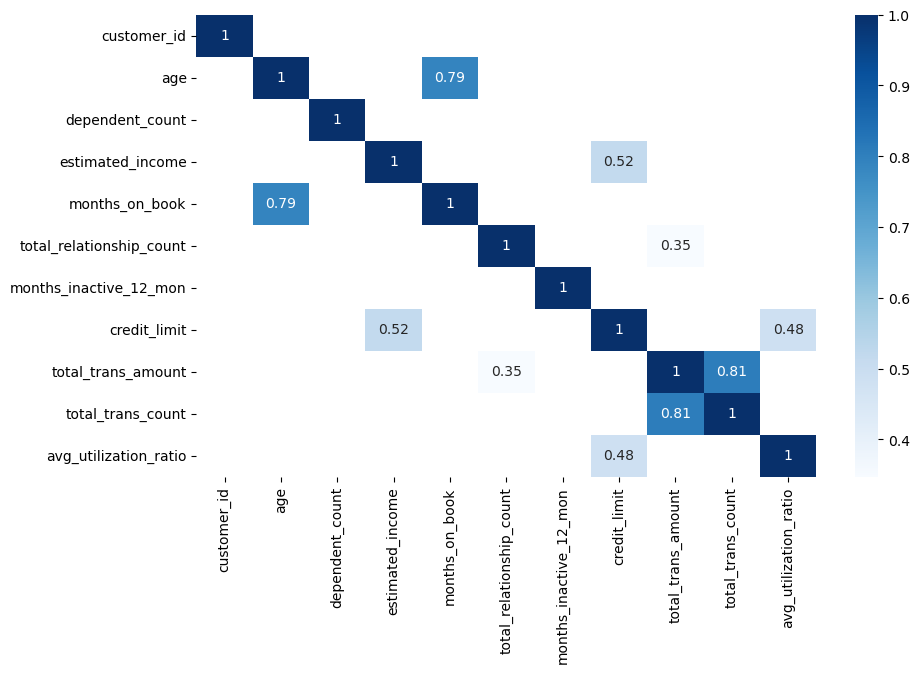

In [19]:
categorical = ['gender', 'education_level', 'marital_status']
numerical_data = data.drop(columns=categorical)
correlations = abs(numerical_data.corr())
plt.figure(figsize = (10,6))
sns.heatmap(correlations[correlations > 0.3], annot=True, cmap="Blues")
plt.show()

From the heatmap above we can see the correlations between numerical columns. The higher the value (the darker the color) is, the higher the correlation is. We filtered the heatmap to only show correlation values over 0.3 and were left with following correlations:
- `months_on_book` correlates with `age` (0.79)
- `estimated_income` correlates with `credit_limit` (0.52)
- `total_relationship_count` correlates with `total_trans_amount` (0.35)
- `credit_limit` correlates with `avg_utilization_ratio` (0.48)
- `total_trans_amount` correlates with `total_trans_count` (0.81)

### Distribution of each numeric column

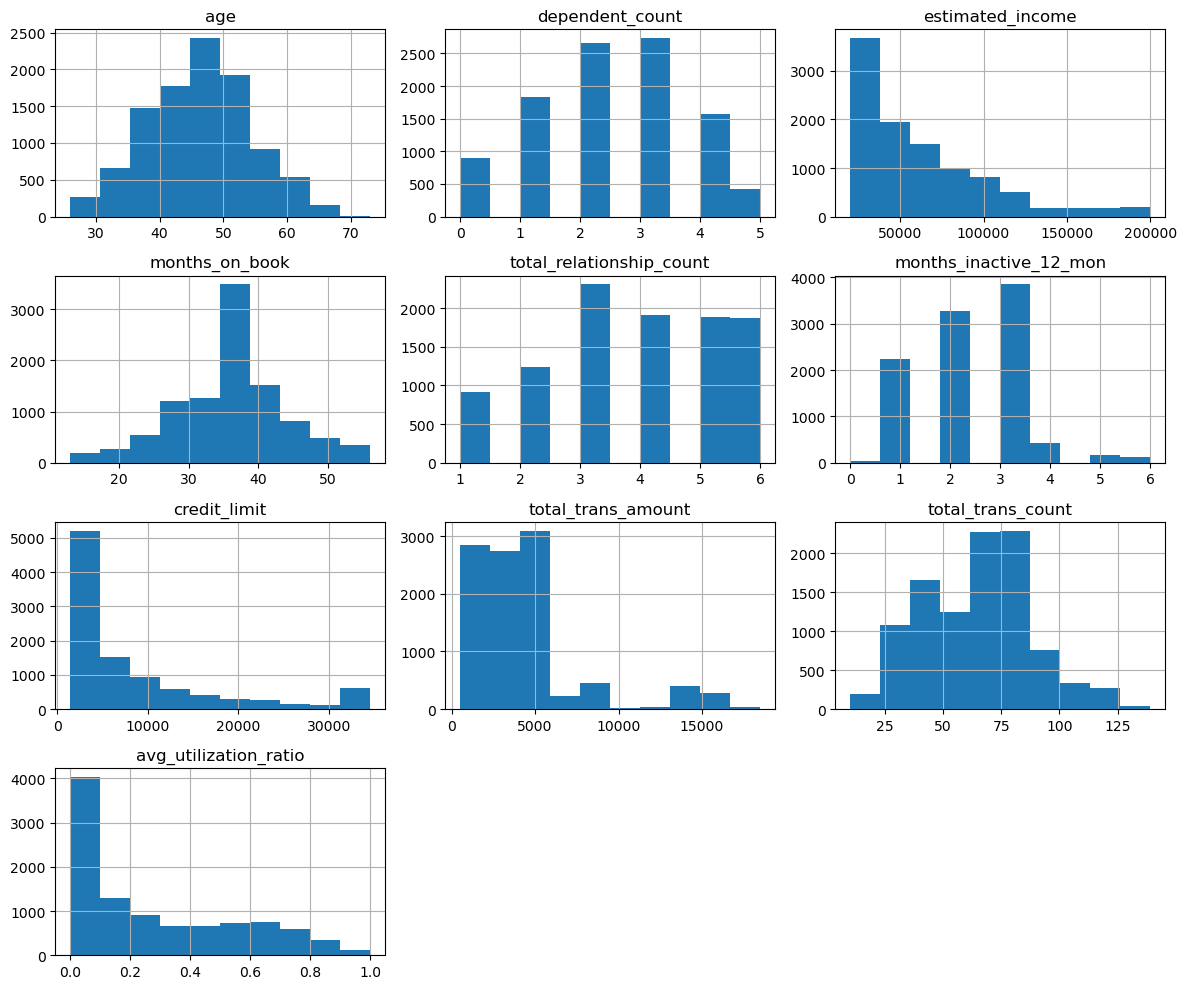

In [20]:
data_to_plot = numerical_data.drop('customer_id', axis=1)

#plot
data_to_plot.hist(figsize=(12, 10))

plt.tight_layout()
plt.show()

Some of the distributions are close to normal distribution, but most of them are not.

## Feature Engineering

In [21]:
print(data['gender'].unique())
print(data['education_level'].unique())
print(data['marital_status'].unique())

['M' 'F']
['High School' 'Graduate' 'Uneducated' 'Post-Graduate' 'College'
 'Doctorate']
['Married' 'Single' 'Unknown' 'Divorced']


Now we are going to deal with categorical columns. Lets start with `gender` and `education level`. The `gender` column contains 2 unique values `M` and `F`, so we can change these to 1 and 0. 

The `education_level` contains 6 unique values. We can replace these with numbers from 0 to 5, because each level of education is ranked higher than the previous level. We will replace them with the following values:
- `Uneducated` - 0
- `High School`- 1
- `College` - 2
- `Graduate` - 3
- `Post-Graduate` - 4
- `Doctorate` - 5

In [22]:
#creating copy
customers_modif = data.copy()
#replacing genders
customers_modif['gender'] = customers_modif['gender'].apply(lambda x: 1 if x == 'M' else 0)
#replacing education levels
customers_modif['education_level'] = np.where(customers_modif['education_level'] == 'Uneducated', 0,
                                     np.where(customers_modif['education_level'] == 'High School', 1,
                                     np.where(customers_modif['education_level'] == 'College', 2,
                                     np.where(customers_modif['education_level'] == 'Graduate', 3,
                                     np.where(customers_modif['education_level'] == 'Post-Graduate', 4,
                                     np.where(customers_modif['education_level'] == 'Doctorate', 5, customers_modif['education_level']))))))

In [23]:
print(customers_modif['gender'].unique())
print(customers_modif['education_level'].unique())

[1 0]
[1 3 0 4 2 5]


The `marital_status` column contains the following values:
- Single
- Married
- Divorce
- Unknown

We can't do the same for `marital_status` column that we did for the `education_level` column. There are no clear ranks between these values, so we can't just assign them values between 0 and 3. Because of this, we will create dummy variables.

In [24]:
dummies = pd.get_dummies(customers_modif[['marital_status']], drop_first=True)

customers_modif = pd.concat([customers_modif, dummies],axis=1)
customers_modif = customers_modif.drop(columns='marital_status', axis=1)
print(customers_modif.shape)
customers_modif

(10127, 16)


,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,True,False,False
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,False,True,False
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,True,False,False
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,False,False,True
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,1,2,3,51000,40,3,2,4003.0,15476,117,0.462,False,True,False
10123,710638233,41,1,2,3,40000,25,4,2,4277.0,8764,69,0.511,False,False,False
10124,716506083,44,0,1,1,33000,36,5,3,5409.0,10291,60,0.000,True,False,False
10125,717406983,30,1,2,3,47000,36,4,3,5281.0,8395,62,0.000,False,False,True


Now we have dealed with the categorical values.

## Scaling the Data

Our data is differently scaled across the DataFrame (for example `education_level` contains numbers from 0-5, `gender` only from 0-1, income can be tens of thousands etc.). We need to scale the data so it's all on the same scale.

In [28]:
#dropping customer id
customers_for_scale = customers_modif.drop(columns='customer_id', axis=1)
print(customers_for_scale.shape)

scaler = StandardScaler()
#fit
scaler.fit(customers_for_scale)
#transform
customers_scaled = scaler.transform(customers_for_scale)
customers_scaled = pd.DataFrame(customers_scaled)
customers_scaled.head()

(10127, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.165406,1.059956,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,1.077338,-0.798507,-0.282609
1,0.333570,-0.943436,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,-0.928214,1.252337,-0.282609
2,0.583058,1.059956,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,1.077338,-0.798507,-0.282609
3,-0.789126,-0.943436,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,-0.928214,-0.798507,3.538459
4,-0.789126,1.059956,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,1.077338,-0.798507,-0.282609


Above we have all the scaled values.

## Choosing K

Our dataset is now ready for machine learning. Next we have to decide what is the best number of clusters to use in segmentation according to the inertia metric. To do that, we have to loop multiple different models and plot the Elbow Curve to find out what's the best number of clusters.

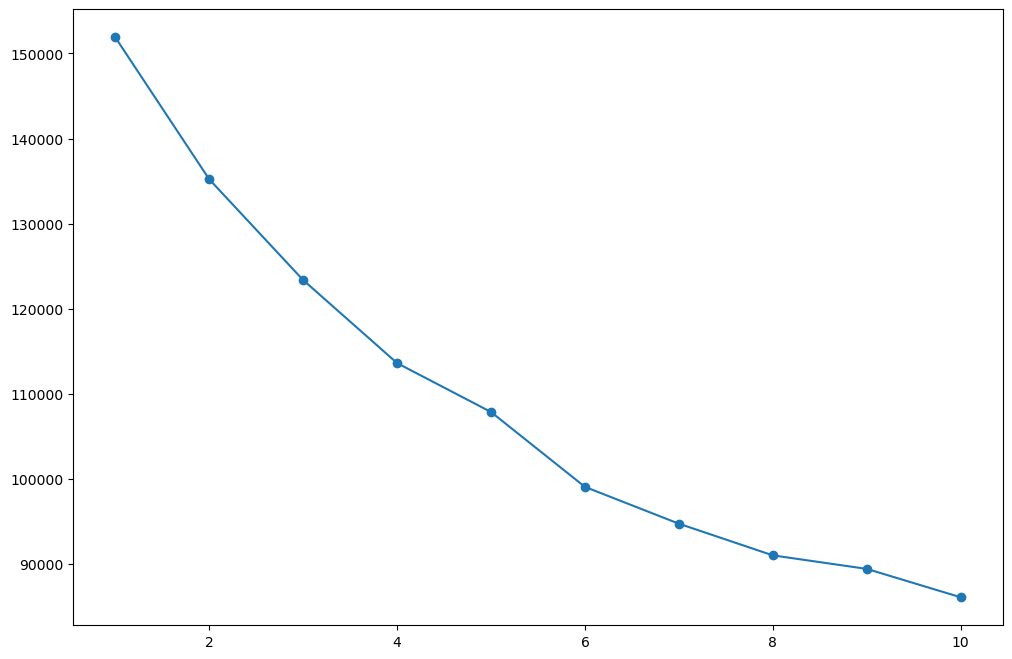

In [44]:
inertias = []
for k in range (1,11):
    kmean = KMeans(n_clusters=k)
    kmean_fit = kmean.fit_predict(customers_scaled)
    inertia = kmean.inertia_
    inertias.append(inertia)

plt.figure(figsize=(12,8))
plt.plot(range(1,11),inertias, marker='o')
plt.show()

From the plot above we can see that it is not a 'clear elbow', but the best k-value would most likely be 6 (it looks to be somewhere between 5 and 7). After that the line starts to level off. Let's now instantiate a new Kmeans object, with K value of 6.

In [46]:
kmean = KMeans(n_clusters=6)
clusters = kmean.fit_predict(customers_scaled)
clusters

array([1, 4, 1, ..., 3, 0, 3], dtype=int32)

## Analyzing Results

Now we are going to analyze the results. We need to see how the variables used in the clusterization differ from cluster to cluster in order to explain what each cluster represents.

In [55]:
#clusters starting from 1, so +1
data['CLUSTER'] = clusters+1
data.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,CLUSTER
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,2
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,5
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,2
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,1
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,4


In [56]:
data['CLUSTER'].value_counts()

CLUSTER
4    2815
5    2448
2    1784
3    1443
6     908
1     729
Name: count, dtype: int64

Now each customer has a cluster assigned. Let's now group each numeric variable by the cluster column and plot a bar chart to see which characteristics belong to each cluster.

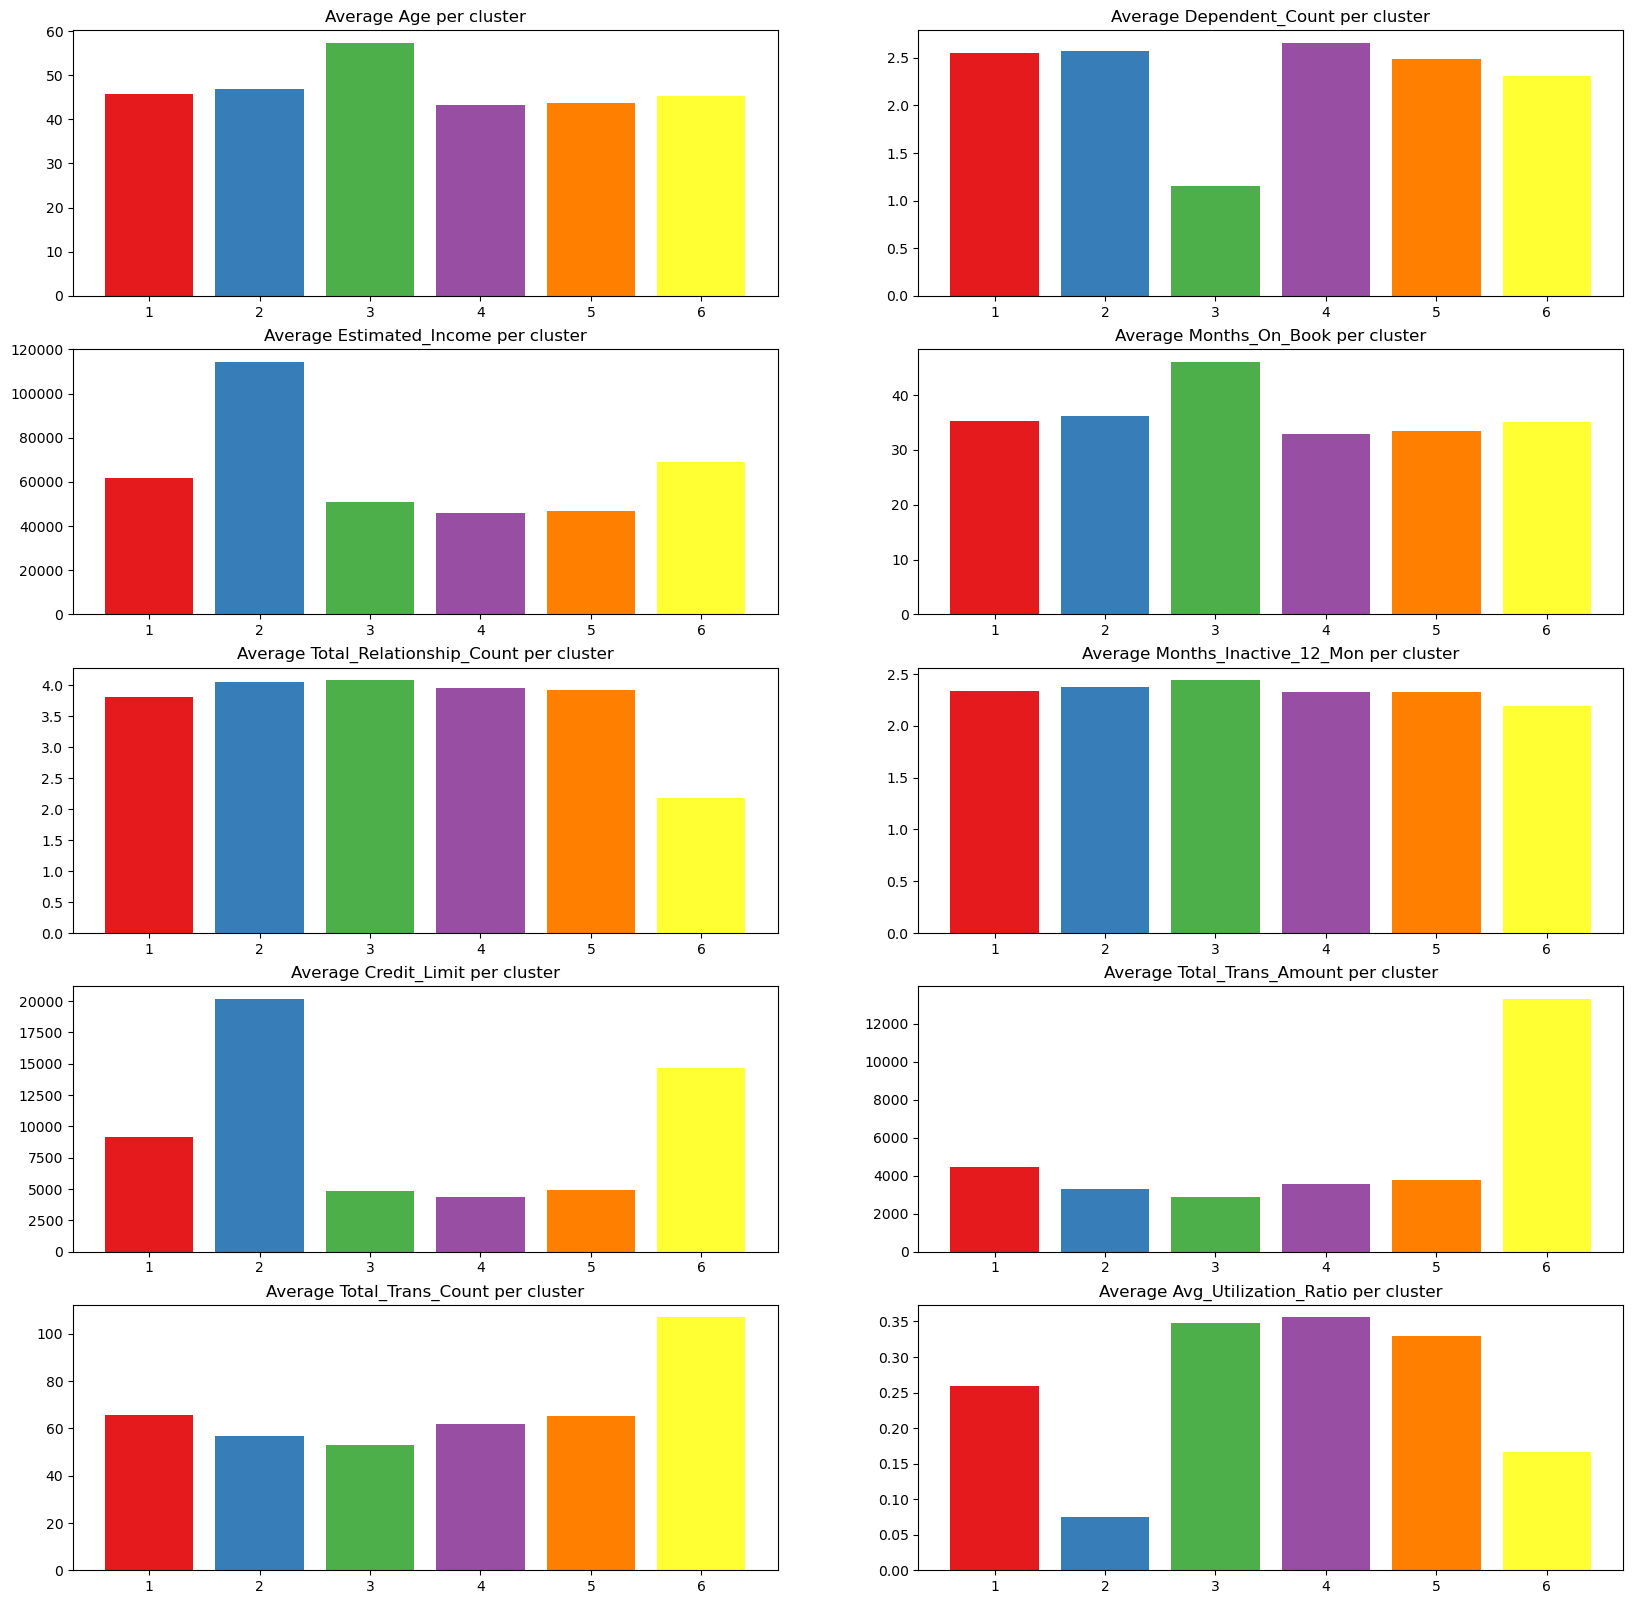

In [65]:
numeric_columns = data.select_dtypes(include=np.number).drop(['customer_id', 'CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(20,20))
for index, column in enumerate(numeric_columns):
    plot_data = numerical_data.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(5,2, index+1)
    ax.bar(plot_data.index, plot_data, color=sns.color_palette('Set1'))
    ax.set_title(f'Average {column.title()} per cluster')

plt.show()

From the bar charts above we can see some characteristics for each cluster. For example:
- All clusters have average age close to other clusters (cluster 3 has the highest avg age)
- Cluster 3 has a very low value of Average Dependent Count
- Cluster 2 has the highest estimated income
- Cluster 6 has the lowest total relationship count
- Average credit limit is very high for clusters 2 and 6.
- Average total trans amount and total trans count is very high for cluster 6.
- Cluster 2 has low avg utilization ratio.

Let's now create a scatter plot with different colors for each cluster of pairs of variables with a high correlation. We already calculated the correlations earlier and find out that:
- `months_on_book` correlates with `age` (0.79)
- `estimated_income` correlates with `credit_limit` (0.52)
- `total_relationship_count` correlates with `total_trans_amount` (0.35)
- `credit_limit` correlates with `avg_utilization_ratio` (0.48)
- `total_trans_amount` correlates with `total_trans_count` (0.81)

Let's plot all those that have correlation over 0.4.

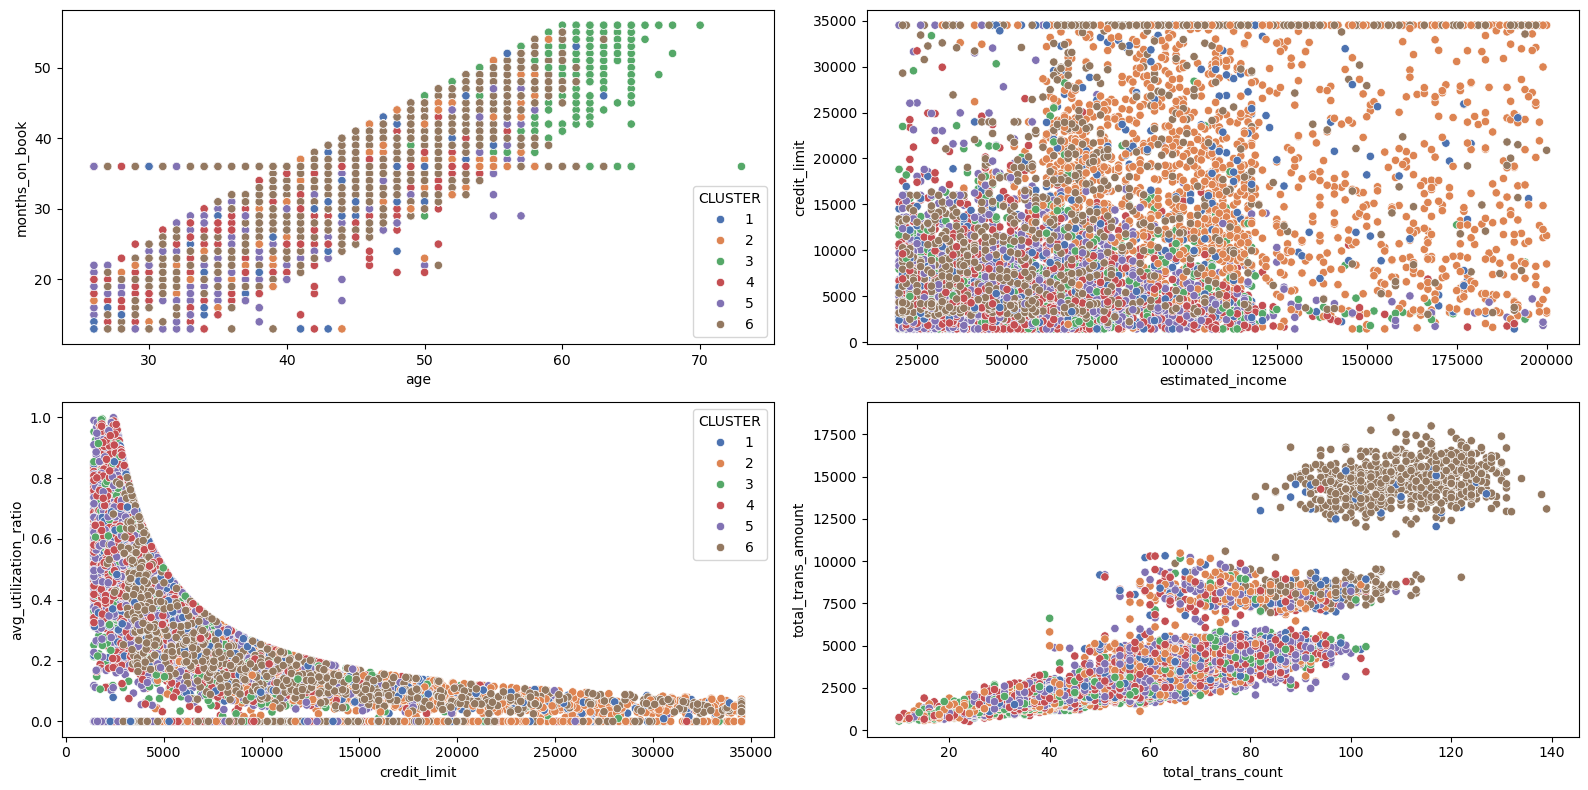

In [82]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=data, palette='deep', ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=data, palette='deep', ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=data, palette='deep', ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=data, palette='deep', ax=ax4, legend=False)

plt.tight_layout()
plt.show()

From these scatterplots we can also see some patterns, for example cluster 3 contains clearly the oldest people with most `months_on_book`, while cluster 6 contains high `total_trans_count` and `total_trans_amount`. Let's next create a crosstable to find a percentual distribution of each variable per cluster for the categorical columns, and create a stacked bar chart from the crosstable.

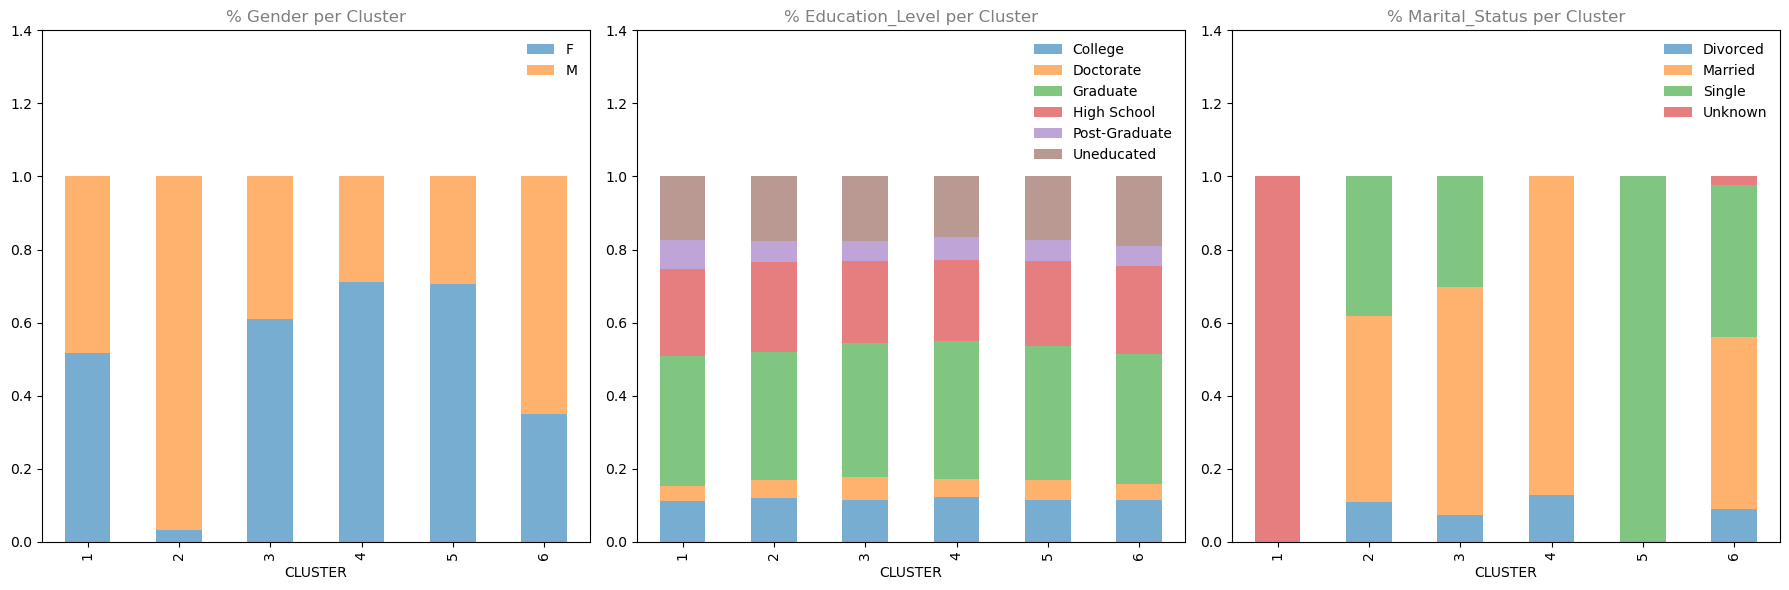

In [91]:
categorical = ['gender', 'education_level', 'marital_status']

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(categorical):
    plot_df = pd.crosstab(index=data['CLUSTER'], columns=data[col], values=data[col], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, 3, i+1)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {col.title()} per Cluster', alpha=0.5)

    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    
    
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]

plt.tight_layout()
plt.show()

From the bar charts above we can see that cluster 2 contains almost only males. The education level is divided between each cluster. Cluster 1 contains only unknown marital status, while cluster 5 contains only single marital status. Cluster 4 is almost only married people.

## Conclusion

We have now listed the most important characteristics for each cluster. Here are each cluster with their characteristics, and some recommendations for marketing and business team what to do with each cluster.

### Cluster 1

Both male and female, marital status unknown. Average estimated income, with fairly low transaction amount. This cluster doesn't really shine out on any variable. Also has the lowest value of customers.

### Cluster 2

Almost only males. Very high credit limit and very high income. The amount of transactions and avg utilization rates are very low. Could be incentivized to use their credit card more.

### Cluster 3

Both male and female, but little bit more females, mainly married and single. Low dependent count and average income. This cluster has the highest age and months on book. Their credit limit is low, and they don't do multiple transactions, but they have a high utilization rate. These are older people that are long time customers. They could receive some long-term customer benefits to give incentive to spend more money.

## Cluster 4

Mostly females that are married. Highest dependent count, with low credit limits and low transaction amounts. The average utilization ratio is very high, so they use credit as much as possible, maybe even too much with their income.

## Cluster 5

Again mostly females, but this time they are all single. They have fairly high dependent count. They also have pretty low income, but high utilization rate, meaning that they use their credit card a lot, even with low credit and low income. Their credit could be increased a little bit to increase spending, but not too much.

### Cluster 6

This cluster is mainly males with above average incomes.They have a low relationship with the company, meaning that they haven't contacted the company a lot. They have higher credit limits, and high transaction amounts and counts. The utilization rate is still fairly low, so they could use their credit cards more. The company could reach out to these people to get a better relationship with them, and to give an incentive to spend more.